In [2]:
!pip install scikit-learn
!pip install tensorflow

In [10]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import wavfile


In [11]:
data_paths = []
label_tags = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'go', 'on', 'off', 'stop']

In [12]:
for directory, subdirectories, files in os.walk("../../../Data/"):

    phn_dir = ""
    wav_dir = ""
    prompts_dir = ""

    for subdirectory in subdirectories:

        if subdirectory.startswith("phn_"):
            phn_dir = os.path.join(directory, subdirectory)

        elif phn_dir and subdirectory.startswith("wav_"):
            if (phn_dir.endswith("headMic") and subdirectory.endswith("headMic")) or (phn_dir.endswith("arrayMic") and subdirectory.endswith("arrayMic")):
                wav_dir = os.path.join(directory, subdirectory)

        elif subdirectory.startswith("prompts"):
            prompts_dir = os.path.join(directory, subdirectory)

    if phn_dir and wav_dir and prompts_dir:
        data_paths.append((phn_dir, wav_dir, prompts_dir))

valid_data = []
for paths in data_paths:
    for filename in os.listdir(paths[2]):
        with open(os.path.join(paths[2], filename)) as f:
            prompt = f.readline().rstrip().lower()
            if prompt not in label_tags:
                continue
        phn_fullpath = os.path.join(paths[0], os.path.splitext(os.path.basename(filename))[0] + ".phn")
        if not os.path.exists(phn_fullpath):
            print("Matching phoneme file not found for {}".format(filename))
            continue
        lines = []
        with open(phn_fullpath) as f:
            lines = f.read().splitlines()

        if len(lines) < 2:
            continue 

        wav_fullpath = os.path.join(paths[1], os.path.splitext(os.path.basename(filename))[0] + ".wav")

        if not os.path.exists(wav_fullpath):
            continue

        valid_data.append(wav_fullpath)


Matching phoneme file not found for 0082.txt
Matching phoneme file not found for 0144.txt
Matching phoneme file not found for 0156.txt
Matching phoneme file not found for 0172.txt
Matching phoneme file not found for 0184.txt
Matching phoneme file not found for 0185.txt
Matching phoneme file not found for 0199.txt
Matching phoneme file not found for 0220.txt
Matching phoneme file not found for 0038.txt
Matching phoneme file not found for 0039.txt
Matching phoneme file not found for 0049.txt
Matching phoneme file not found for 0058.txt
Matching phoneme file not found for 0074.txt
Matching phoneme file not found for 0080.txt
Matching phoneme file not found for 0107.txt
Matching phoneme file not found for 0118.txt
Matching phoneme file not found for 0124.txt
Matching phoneme file not found for 0108.txt


In [175]:
def get_label(path):
    path = os.path.normpath(path)
    path_parts = os.path.split(path)
    prompt_number = os.path.splitext(path_parts[-1])[0]
    prefix, _ = os.path.split(path_parts[0])
    prompt_path = os.path.join(prefix, "prompts", prompt_number + ".txt")

    with open(prompt_path) as f:
        prompt = f.readline().rstrip().lower()
        return prompt

In [205]:
def cut_audio(path, audio):
    path = os.path.normpath(path)
    path_parts = os.path.split(path)
    phoneme_number = os.path.splitext(path_parts[-1])[0]
    prefix, audio_type = os.path.split(path_parts[0])
    phoneme_type = audio_type.split('_')[-1]
    phoneme_folder = "phn_" + phoneme_type

    phoneme_path = os.path.join(prefix, phoneme_folder, phoneme_number + ".phn")

    lines = []
    with open(phoneme_path) as f:
        lines = f.read().splitlines()

    wav_start = int(lines[1].rstrip().split(" ")[0])

    last_line = lines[-1].rstrip().split(" ")

    if last_line[-1] == "sil" or last_line[-1] == "noi":
        last_line = lines[-2].rstrip().split(" ")
    
    wav_end = int(last_line[1])

    if wav_start >= np.shape(audio)[0] or wav_end > np.shape(audio)[0]:
        print("Wrong timestamps in file: {}", phoneme_path)
        return []
    
    return audio[wav_start:wav_end]

In [206]:
def read_audio(path):
    audio = []

    try:
        sample, wav_array = sio.wavfile.read(path)
        print("Loaded WAV file: {}. SR: {}. Len: {}.".format(path, sample, np.shape(wav_array)[0]))
        wav_array = wav_array.astype('float32')
        audio = wav_array / np.max(np.abs(wav_array), axis=0)
        audio = cut_audio(path, audio)

    except ValueError:
        print("Corrupted WAV file: {}".format(path))
    
    return audio

In [207]:
def get_waveform_and_label(path):
    audio = read_audio(path)
    label = get_label(path)
    return (audio, label)

In [208]:
waves = []
labels = []
idx = 0
for path in valid_data:
    wave, label = get_waveform_and_label(path)
    if len(wave) == 0:
        continue
    if idx == 14:
        print(path)
    waves.append(wave)
    labels.append(label)
    idx += 1



Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0010.wav. SR: 16000. Len: 31200.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0018.wav. SR: 16000. Len: 21600.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0047.wav. SR: 16000. Len: 24000.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0049.wav. SR: 16000. Len: 16800.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0086.wav. SR: 16000. Len: 24000.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0088.wav. SR: 16000. Len: 24000.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0112.wav. SR: 16000. Len: 26400.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0123.wav. SR: 16000. Len: 33600.
Loaded WAV file: ../../../Data/A_F\F01\Session1\wav_arrayMic\0134.wav. SR: 16000. Len: 21600.
Loaded WAV file: ../../../Data/A_F\F03\Session1\wav_arrayMic\0041.wav. SR: 16000. Len: 19200.
Loaded WAV file: ../../../Data/A_F\F03\Session1\wav_arrayMic

In [261]:
def standardize_wave(wave):
    wave = np.array(wave)
    wave_size = np.shape(wave)[0]
    if wave_size > 16000:
        wave = wave[0:16000]
    elif wave_size < 16000:
        wave = np.pad(wave, (0, 16000 - wave_size), mode='constant')
    return wave


In [274]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
classes = list(le.classes_)


In [275]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(classes))

In [276]:
waves = np.array([standardize_wave(wave) for wave in waves])

In [277]:
# From https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74
from scipy.fftpack import fft
from scipy import signal

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is symmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=16,
                 step_size=8, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

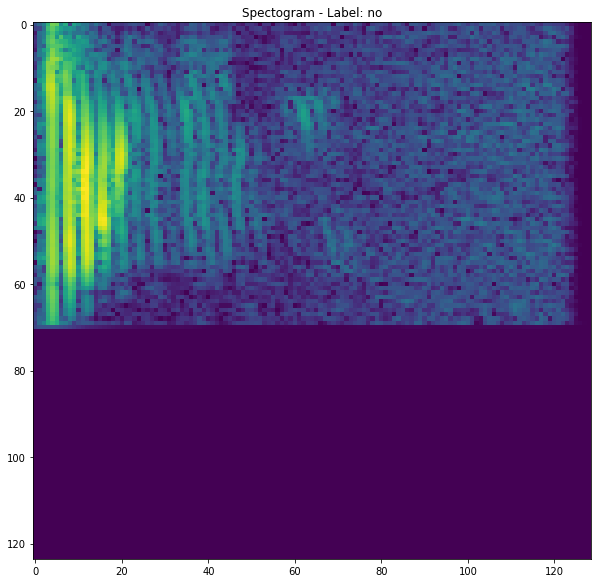

In [317]:
spectrograms = []
for wave in waves:
    _, _, specgram = log_specgram(wave, sample_rate=16000)
    spectrograms.append(specgram)

spectrograms = np.array(spectrograms)

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
#ax1.set_xticks([])
#ax1.set_yticks([])

idx = 1
ax1.set_title('Spectogram - Label: {}'.format(labels[idx]))
ax1.imshow(spectrograms[idx])

In [359]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(spectrograms),np.array(y),stratify=y,test_size = 0.2,random_state=666,shuffle=True)

In [360]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(124, 129, 1))

conv = Conv2D(4, 3, padding='same', activation='relu', strides=1)(inputs)
conv = MaxPooling2D(2)(conv)
#conv = Dropout(0.2)(conv)

conv = Conv2D(16, 3, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling2D(2)(conv)
#conv = Dropout(0.2)(conv)

conv = Conv2D(64, 3, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling2D(2)(conv)
#conv = Dropout(0.2)(conv)

#conv = Conv2D(64, 3, padding='same', activation='relu', strides=1)(inputs)
#conv = MaxPooling2D(2)(conv)
#conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(64, activation='relu')(conv)
#conv = Dropout(0.2)(conv)

#Dense Layer 2
#conv = Dense(128, activation='relu')(conv)
#conv = Dropout(0.2)(conv)

outputs = Dense(len(classes), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 129, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 64, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 63488)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4063296   
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1105      
Total params: 4,064,561
Trainable params: 4,064,561
Non-trainable params: 0
___________________________________________________

In [361]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=1, validation_data=(x_val,y_val))

Epoch 1/10
72/72 [==============================] - 2s 31ms/step - loss: 857.7034 - accuracy: 0.0473 - val_loss: 2.8243 - val_accuracy: 0.1053
Epoch 2/10
72/72 [==============================] - 2s 31ms/step - loss: 2.8132 - accuracy: 0.1269 - val_loss: 2.8158 - val_accuracy: 0.1053
Epoch 3/10
72/72 [==============================] - 2s 29ms/step - loss: 2.8023 - accuracy: 0.0546 - val_loss: 2.8082 - val_accuracy: 0.1579
Epoch 4/10
72/72 [==============================] - 2s 29ms/step - loss: 2.7872 - accuracy: 0.1088 - val_loss: 2.8016 - val_accuracy: 0.1579
Epoch 5/10
72/72 [==============================] - 2s 30ms/step - loss: 2.7886 - accuracy: 0.1187 - val_loss: 2.7957 - val_accuracy: 0.1579
Epoch 6/10
72/72 [==============================] - 2s 30ms/step - loss: 2.7673 - accuracy: 0.1086 - val_loss: 2.7907 - val_accuracy: 0.1579
Epoch 7/10
72/72 [==============================] - 2s 30ms/step - loss: 2.7347 - accuracy: 0.2143 - val_loss: 2.7864 - val_accuracy: 0.1579
Epoch 8/10


In [371]:
def predict(audio):
    prob=model.predict(audio.reshape(1, 124, 129, 1))
    index=np.argmax(prob[0])
    print(prob)
    return classes[index]

import random

index=random.randint(0,len(x_val)-1)
samples=x_val[index]
print(np.shape(samples))
print("Audio:",classes[np.argmax(y_val[index])])

#ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

(124, 129)
Audio: zero
[[0.05856649 0.04484656 0.0479609  0.06203619 0.04791689 0.05672508
  0.0481391  0.09399455 0.06295731 0.06075561 0.05276838 0.04593439
  0.04948862 0.06094709 0.06845205 0.09226766 0.04624325]]
Text: no
